In [158]:
 from julia import Julia
jl = Julia(sysimage = "/home/callum/ASF/Fitting/sys_model.so") #loading sys image

In [28]:
import matplotlib.pyplot as plt

import os
import tempfile
import numpy as np
import scipy as sp


from pyabc import ABCSMC, RV, Distribution, LocalTransition, MedianEpsilon, SingleCoreSampler
from pyabc.visualization import plot_data_callback, plot_kde_2d
from pyabc.populationstrategy import AdaptivePopulationSize
import pyabc
from scipy import stats
import random as rd
from brokenaxes import brokenaxes

In [365]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [385]:
plt.style.use('seaborn-colorblind')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [185]:
def read_inputs(path,number):
    
    models = [1,2,3,4]
    
    if number not in models:
        raise Exception("Model number must be 1, 2, 3 or 4") 
        
    weights = np.genfromtxt(path + "/h{}_weights.csv".format(number), delimiter=',')
    params = np.genfromtxt(path + "/h{}_params.csv".format(number), delimiter=',')
    
    nparams = params.shape[1]
    
    p1_dis = stats.gaussian_kde(params[:,0],weights = weights)
    p2_dis = stats.gaussian_kde(params[:,1],weights = weights)
    
    if nparams == 2:
        return p1_dis, p2_dis
    elif nparams == 3:
        p3_dis = stats.gaussian_kde(params[:,2],weights = weights)
        return p1_dis, p2_dis, p3_dis
    

In [196]:
def run_simulations(path,number,n_sims, median = False, distance = False):
    
    posteriors = read_inputs(path,number)
    
    n_params = len(posteriors) #two or three fitted parameters!
    
    store  = np.zeros((n_sims,3))
    
    dd = 0
    n_samples = 100000
    
    dp1 = posteriors[0].resample(n_samples)[0]
    dp2 = posteriors[1].resample(n_samples)[0]

    rd.shuffle(dp1)
    rd.shuffle(dp2)
    
    if n_params == 3:
        dp3 = posteriors[2].resample(n_samples)[0]
        rd.shuffle(dp3)
        
    if median:
        if n_params == 2:
            p = {"p1":np.median(dp1),"p2":np.median(dp2)}
        elif n_params ==3:
            p = {"p1":np.median(dp1),"p2":np.median(dp2), "p3":np.median(dp3)}
            
    for i in range(n_sims):
        
        if not median:
            if n_params == 2:
                p = {"p1":dp1[i],"p2":dp2[i]}
            elif n_params ==3:
                p = {"p1":dp1[i],"p2":dp2[i], "p3":dp3[i]}

        
        
        if number == 1:
            out = model1(p)
            
        elif number == 2:
             out = model2(p)
                
        elif number == 3:
             out = model3(p)
                
        else:
             out = model4(p)

        
        store[i] = out["SS"][0:3]
        dd += out["SS"][3]
    print("Finished")
    if distance:
        dis, mean, c95 = distance_from_mean(store)
        
        return store, dis, mean, c95
    
    else:        
        return store, dd
    
    
        
        

In [7]:
def distance_from_mean(store):
    
    mean_ep = 1.5
    std_ep = 0.604

    mean_pd = 75
    std_pd = 6.08

    mean_mt = 180
    std_mt = 36.475

    
    store_t = (store -[mean_ep, mean_pd, mean_mt]) / ([std_ep, std_pd, std_mt])
    
    d = np.linalg.norm(store_t,axis=1)
    
    mean = np.mean(d)
    c_95 = np.percentile(d,[2.5, 97.5])
    
    print('Mean distance = ', mean)
    print('95% confidence interval =', c_95)
    
    return d, mean, c_95

In [50]:
def distri(data):
    nt =  data.n_populations - 1 
    h_ws = data.get_distribution(t=nt)[1]
    h_p1 = data.get_distribution(t=nt)[0]['p1'].values
    h_p2 = data.get_distribution(t=nt)[0]['p2'].values
    h_p3 = data.get_distribution(t=nt)[0]['p3'].values

    p1_dis = stats.gaussian_kde(h_p1,weights = h_ws)
    p2_dis = stats.gaussian_kde(h_p2,weights = h_ws)
    p3_dis = stats.gaussian_kde(h_p3,weights = h_ws)

    return p1_dis, p2_dis, p3_dis

In [77]:
def run_sim(data,n_sims, modeln):
    p1, p2,p3 = distri(data)
    store  = np.zeros((n_sims,3))
    
    dp1 = p1.resample(n_sims)[0]
    dp2 = p2.resample(n_sims)[0]
    dp3 = p3.resample(n_sims)[0]
    
    for i in range(n_sims):
        
        
        p = {"p1":dp1[i],"p2":dp2[i], "p3":dp3[i]}
        #p = {"p1":np.average(p1_h1, weights=w_h1),"p2":np.average(p2_h1, weights=w_h1)}
        out = modeln(p)
        
        store[i] = out["SS"]
    
    
    store_t = (store - obs["SS"]) / ([std_ep, std_pd, std_mt])
    
    d = np.linalg.norm(store_t,axis=1)
    
    mean = np.mean(d)
    c_95 = np.percentile(d,[2.5, 97.5])
    
    print('Mean distance = ', mean)
    print('95% confidence interval =', c_95)
    
    return store#mean, c_95

In [21]:
mean_ep = 1.5
std_ep = 0.604

mean_pd = 75
std_pd = 6.08

mean_mt = 180
std_mt = 36.475



In [22]:
ode_1 = run_simulations("Posteriors/ODE/", 1, 10000)
ode_2 = run_simulations("Posteriors/ODE/", 2, 10000)
ode_3 = run_simulations("Posteriors/ODE/", 3, 10000)
ode_4 = run_simulations("Posteriors/ODE/", 4, 10000)

Finished
Finished
Finished
Finished


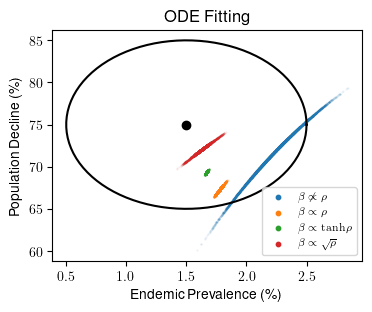

In [23]:
plt.figure(figsize=(4, 3))

plt.scatter(ode_1[:,0], ode_1[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \not \propto \rho$")
plt.scatter(ode_2[:,0], ode_2[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \propto \rho$")
plt.scatter(ode_3[:,0], ode_3[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \propto \tanh{\rho}$")
plt.scatter(ode_4[:,0], ode_4[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt{\rho}$")
#plt.xlim([0,10])
#plt.ylim([0,100])

lgnd = plt.legend(loc="lower right", numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
u=1.5     #x-position of the center
v=75    #y-position of the center
a=1    #radius on the x-axis
b=10    #radius on the y-axis

plt.plot(u,v,"ko")

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), "k" )
    
plt.xlabel(r"Endemic Prevalence (\%)")
plt.ylabel(r"Population Decline (\%)")
plt.title("ODE Fitting")
plt.savefig('odecomp01.pdf', format='pdf', bbox_inches='tight')

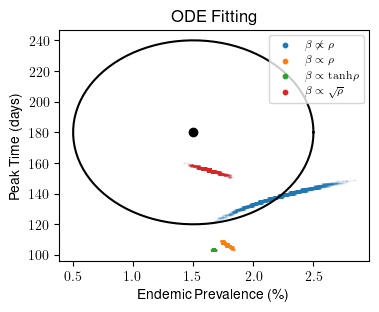

In [24]:
plt.figure(figsize=(4, 3))

plt.scatter(ode_1[:,0], ode_1[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \not \propto \rho$")
plt.scatter(ode_2[:,0], ode_2[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \propto \rho$")
plt.scatter(ode_3[:,0], ode_3[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \propto \tanh{\rho}$")
plt.scatter(ode_4[:,0], ode_4[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt{\rho}$")
#plt.xlim([0,10])
#plt.ylim([0,100])

lgnd = plt.legend(loc="upper right", numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
u=1.5     #x-position of the center
v=180    #y-position of the center
a=1    #radius on the x-axis
b=60    #radius on the y-axis

plt.plot(u,v,"ko")

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), "k" )
    
plt.xlabel(r"Endemic Prevalence (\%)")
plt.ylabel("Peak Time (days)")
plt.title("ODE Fitting")

plt.savefig('odecomp02.pdf', format='pdf', bbox_inches='tight')

In [30]:
ode_1_p = read_inputs("Posteriors/ODE/", 1)
ode_2_p = read_inputs("Posteriors/ODE/", 2)
ode_3_p = read_inputs("Posteriors/ODE/", 3)
ode_4_p = read_inputs("Posteriors/ODE/", 4)

In [379]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [381]:
plt.style.use('seaborn-colorblind')

In [377]:
plt.style.use('default')

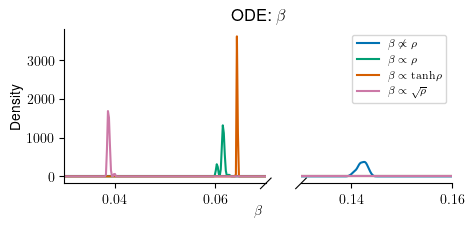

In [386]:
fig = plt.figure(figsize=(5, 2))
bax = brokenaxes(xlims=((0.03, 0.07), (.13, .16)), hspace=.05)
x = np.linspace(0, 0.2, 1000)

#bax.vlines(np.median(shh1p2), 0, hh1_p2.pdf(np.median(shh1p2))[0], ls = '--', color = colors[0])
#bax.vlines(np.median(shh2p2), 0, hh2_p2.pdf(np.median(shh2p2))[0], ls = '--', color = colors[1])
#bax.vlines(np.median(shh3p2), 0, hh3_p2.pdf(np.median(shh3p2))[0], ls = '--', color = colors[2])
#bax.vlines(np.median(shh4p2), 0, hh4_p2.pdf(np.median(shh4p2))[0], ls = '--', color = colors[3])


#bax.plot(x, ode_1_p[0].pdf(x), label =  r"$\beta \not \propto \rho$", color = colors[0])
#bax.plot(x, ode_2_p[0].pdf(x), label =  r"$\beta \propto \rho$", color = colors[1])
#bax.plot(x, ode_3_p[0].pdf(x), label =  r"$\beta \propto \tanh \rho$", color = colors[2])
#bax.plot(x, ode_4_p[0].pdf(x), label =  r"$\beta \propto  \sqrt \rho$", color = colors[3])

bax.plot(x, ode_1_p[0].pdf(x), label =  r"$\beta \not \propto \rho$", color = colors[0])
bax.plot(x, ode_2_p[0].pdf(x), label =  r"$\beta \propto \rho$", color = colors[1])
bax.plot(x, ode_3_p[0].pdf(x), label =  r"$\beta \propto \tanh \rho$", color = colors[2])
bax.plot(x, ode_4_p[0].pdf(x), label =  r"$\beta \propto  \sqrt \rho$", color = colors[3])

bax.legend(fontsize=8)
bax.set_xlabel(r'$\beta$')
bax.set_ylabel("Density")
bax.set_title(r"ODE: $\beta$")
plt.savefig('ode_beta.pdf', format='pdf', bbox_inches='tight')

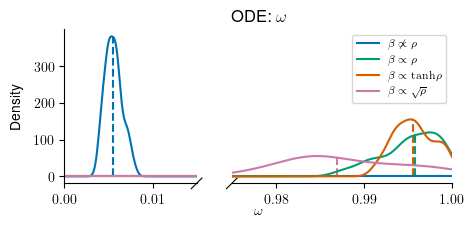

In [387]:
fig = plt.figure(figsize=(5, 2))
bax = brokenaxes(xlims=((0, 0.015), (.975, 1.0)), hspace=.05)
x = np.linspace(0, 1, 10000)
n_samples = 1000000

bax.vlines(np.median(sh1p2), 0, ode_1_p[1].pdf(np.median(sh1p2))[0], ls = '--', color = colors[0])
bax.vlines(np.median(sh2p2), 0, ode_2_p[1].pdf(np.median(sh2p2))[0], ls = '--', color = colors[1])
bax.vlines(np.median(sh3p2), 0, ode_3_p[1].pdf(np.median(sh3p2))[0], ls = '--', color = colors[2])
bax.vlines(np.median(sh4p2), 0, ode_4_p[1].pdf(np.median(sh4p2))[0], ls = '--', color = colors[3])


bax.plot(x, ode_1_p[1].pdf(x), label =  r"$\beta \not \propto \rho$", color = colors[0])
bax.plot(x, ode_2_p[1].pdf(x), label =  r"$\beta \propto \rho$", color = colors[1])
bax.plot(x, ode_3_p[1].pdf(x), label =  r"$\beta \propto \tanh \rho$", color = colors[2])
bax.plot(x, ode_4_p[1].pdf(x), label =  r"$\beta \propto  \sqrt \rho$", color = colors[3])

bax.legend(fontsize=8)
bax.set_xlabel(r'$\omega$')
bax.set_ylabel("Density")
bax.set_title(r"ODE: $\omega$")
#tikzplotlib.save("ode_omega.pgf")
plt.savefig('ode_omega.pdf', format='pdf', bbox_inches='tight')

In [340]:
from matplotlib.gridspec import GridSpec

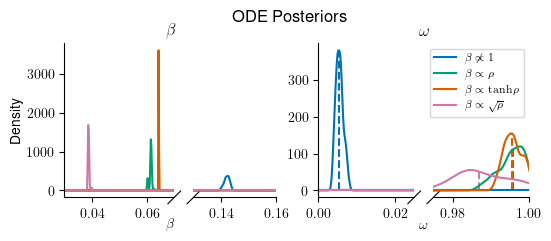

In [454]:
fig = plt.figure(figsize=(6, 2))
sps1, sps2 = GridSpec(1,2)
fig.suptitle('ODE Posteriors',y=1.05)

bax = brokenaxes(xlims=((0.03, 0.07), (.13, .16)), hspace=.05, subplot_spec=sps1)
x = np.linspace(0, 0.2, 1000)

bax.plot(x, ode_1_p[0].pdf(x), label =  r"$\beta \not \propto \rho$", color = colors[0])
bax.plot(x, ode_2_p[0].pdf(x), label =  r"$\beta \propto \rho$", color = colors[1])
bax.plot(x, ode_3_p[0].pdf(x), label =  r"$\beta \propto \tanh \rho$", color = colors[2])
bax.plot(x, ode_4_p[0].pdf(x), label =  r"$\beta \propto  \sqrt \rho$", color = colors[3])


bax.set_xlabel(r'$\beta$')
bax.set_ylabel("Density")
bax.set_title(r"$\beta$")



bax = brokenaxes(xlims=((0, 0.025), (.975, 1.0)), hspace=.05, subplot_spec=sps2)
x = np.linspace(0, 1, 10000)
n_samples = 1000000

bax.vlines(np.median(sh1p2), 0, ode_1_p[1].pdf(np.median(sh1p2))[0], ls = '--', color = colors[0])
bax.vlines(np.median(sh2p2), 0, ode_2_p[1].pdf(np.median(sh2p2))[0], ls = '--', color = colors[1])
bax.vlines(np.median(sh3p2), 0, ode_3_p[1].pdf(np.median(sh3p2))[0], ls = '--', color = colors[2])
bax.vlines(np.median(sh4p2), 0, ode_4_p[1].pdf(np.median(sh4p2))[0], ls = '--', color = colors[3])


bax.plot(x, ode_1_p[1].pdf(x), label =  r"$\beta \not \propto 1$", color = colors[0])
bax.plot(x, ode_2_p[1].pdf(x), label =  r"$\beta \propto \rho$", color = colors[1])
bax.plot(x, ode_3_p[1].pdf(x), label =  r"$\beta \propto \tanh \rho$", color = colors[2])
bax.plot(x, ode_4_p[1].pdf(x), label =  r"$\beta \propto  \sqrt \rho$", color = colors[3])
#bax.axs[0].yaxis.set_major_formatter(EngFormatter())
bax.legend(fontsize=8)
bax.set_xlabel(r'$\omega$')

bax.set_title(r"$\omega$")
plt.savefig('ode_post.pdf', format='pdf', bbox_inches='tight')

In [337]:
n_samples = 1000000
sh1p1= ode_1_p[0].resample(n_samples)
sh2p1= ode_2_p[0].resample(n_samples)
sh3p1= ode_3_p[0].resample(n_samples)
sh4p1= ode_4_p[0].resample(n_samples)


sh1p2= ode_1_p[1].resample(n_samples)
sh2p2= ode_2_p[1].resample(n_samples)
sh3p2= ode_3_p[1].resample(n_samples)
sh4p2= ode_4_p[1].resample(n_samples)

In [130]:

shh1p1= tau_1_p[0].resample(n_samples)
shh2p1= tau_2_p[0].resample(n_samples)
shh3p1= tau_3_p[0].resample(n_samples)
shh4p1= tau_4_p[0].resample(n_samples)

shh1p2= tau_1_p[1].resample(n_samples)
shh2p2= tau_2_p[1].resample(n_samples)
shh3p2= tau_3_p[1].resample(n_samples)
shh4p2= tau_4_p[1].resample(n_samples)

In [121]:
def print_result(data):
    meand = np.mean(data)
    mediand = np.median(data)
    
    print(np.round(meand,3))
    print(np.round(mediand,3))

In [144]:

print_result(shh4p1)
print_result(shh4p2)


0.049
0.047
0.766
0.784


In [157]:

x = np.linspace(0, 1, 100000)
tt = tau_4_p[0].pdf(x)
np.round(x[np.argmax(tt)],3)

0.043

In [ ]:
arg

In [97]:
tauho_1, d1 = run_simulations("Posteriors/Tau-Homogeneous/", 1, 10000)
tauho_2, d2 = run_simulations("Posteriors/Tau-Homogeneous/", 2, 10000)
tauho_3, d3 = run_simulations("Posteriors/Tau-Homogeneous/", 3, 10000)
tauho_4, d4 = run_simulations("Posteriors/Tau-Homogeneous/", 4, 10000)

Finished
Finished
Finished
Finished


In [98]:
tauho_1f  = tauho_1[tauho_1[:,0] > 0]
tauho_2f  = tauho_2[tauho_2[:,0] > 0]
tauho_3f  = tauho_3[tauho_3[:,0] > 0]
tauho_4f  = tauho_4[tauho_4[:,0] > 0]



In [100]:
len(tauho_1f)

6469

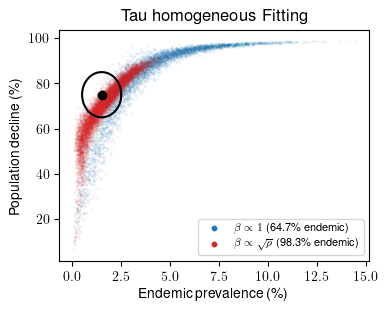

In [261]:
plt.figure(figsize=(4, 3))

plt.scatter(tauho_1f[:,0], tauho_1f[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \propto 1$ ({}\% endemic)".format(round(100*d1/len(tauho_1),1)), color = colors[0])
#plt.scatter(tauho_2f[:,0], tauho_2f[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \propto \rho$, ({}\%)".format(round(100*d2/len(tauho_2),1)))
#plt.scatter(tauho_3f[:,0], tauho_3f[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \propto \tanh(\rho)$, ({}\%)".format(round(100*d3/len(tauho_3),1)))
plt.scatter(tauho_4f[:,0], tauho_4f[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt \rho$ ({}\% endemic)".format(round(100*d4/len(tauho_4),1)),color = colors[3])
#plt.ylim([0,100])

lgnd = plt.legend(loc="lower right", numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
u=1.5     #x-position of the center
v=75    #y-position of the center
a=1    #radius on the x-axis
b=10    #radius on the y-axis

plt.plot(u,v,"ko")

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), "k" )
    
plt.xlabel("Endemic prevalence (\%)")
plt.ylabel("Population decline (\%)")
plt.title("Tau homogeneous Fitting")
plt.savefig('taucomp01f.pdf', format='pdf', bbox_inches='tight')

In [51]:
tauho_1f = tauho_1[tauho_1[:,0] > 0.25]
tauho_2f = tauho_2[tauho_2[:,0] > 0.25]
tauho_3f = tauho_3[tauho_3[:,0] > 0.25]
tauho_4f = tauho_4[tauho_4[:,0] > 0.25]

In [62]:
100-100*(len(tauho_1f)/len(tauho_1))

29.75

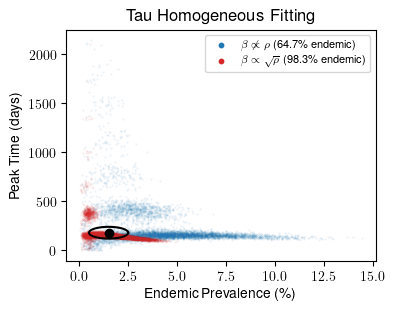

In [262]:
plt.figure(figsize=(4, 3))

plt.scatter(tauho_1f[:,0], tauho_1f[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \not \propto \rho$ ({}\% endemic)".format(round(100*d1/len(tauho_1),1)), color = colors[0])
#plt.scatter(tauho_2f[:,0], tauho_2f[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \propto \rho$, ({}\%)".format(round(100*d2/len(tauho_2),1)))
#plt.scatter(tauho_3f[:,0], tauho_3f[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \propto \tanh(\rho)$, ({}\%)".format(round(100*d3/len(tauho_3),1)))
plt.scatter(tauho_4f[:,0], tauho_4f[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt \rho$ ({}\% endemic)".format(round(100*d4/len(tauho_4),1)), color = colors[3])
#plt.ylim([0,100])
#plt.xlim([0,10])
#plt.ylim([0,100])

lgnd = plt.legend(loc="upper right", numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
u=1.5     #x-position of the center
v=180    #y-position of the center
a=1    #radius on the x-axis
b=60    #radius on the y-axis

plt.plot(u,v,"ko")

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), "k" )
    
plt.xlabel(r"Endemic Prevalence (\%)")
plt.ylabel("Peak Time (days)")
plt.title("Tau Homogeneous Fitting")

plt.savefig('taucomp02f.pdf', format='pdf', bbox_inches='tight')

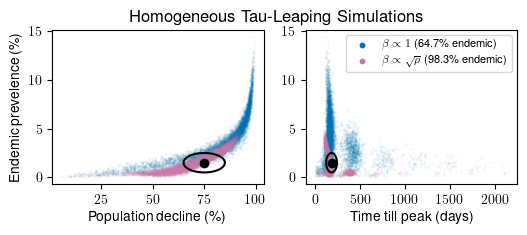

In [455]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6,2))
fig.suptitle('Homogeneous Tau-Leaping Simulations')

ax1.scatter(tauho_1f[:,1], tauho_1f[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto 1$ ({}\% endemic)".format(round(100*d1/len(tauho_1),1)), color = colors[0])
ax1.scatter(tauho_4f[:,1], tauho_4f[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt \rho$ ({}\% endemic)".format(round(100*d4/len(tauho_4),1)),color = colors[3])
    
u=1.5     #x-position of the center
v=75    #y-position of the center
a=1    #radius on the x-axis
b=10    #radius on the y-axis

ax1.plot(v,u,"ko")
t = np.linspace(0, 2*np.pi, 100)
ax1.plot( v+b*np.sin(t), u+a*np.cos(t) ,"k" )


ax2.scatter(tauho_1f[:,2], tauho_1f[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto 1$ ({}\% endemic)".format(round(100*d1/len(tauho_1),1)), color = colors[0])
ax2.scatter(tauho_4f[:,2], tauho_4f[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt \rho$ ({}\% endemic)".format(round(100*d4/len(tauho_4),1)),color = colors[3])

v = 180
b = 60

ax2.plot(v,u,"ko")
ax2.plot( v+b*np.sin(t), u+a*np.cos(t) ,"k" )

ax1.set_ylabel("Endemic prevelence (\%)")
ax1.set_xlabel("Population decline (\%)")
ax2.set_xlabel("Time till peak (days)")

lgnd = ax2.legend(loc=1, numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
plt.savefig('tau_homogeneous_sims.pdf', format='pdf', bbox_inches='tight')

In [456]:
ep1 = np.linspace(0.025, 0.2, 1000)
ep2 = np.linspace(0, 1, 1000)

n_samples = 1000000
shh1p1= tau_1_p[0].resample(n_samples)
shh2p1= tau_2_p[0].resample(n_samples)
shh3p1= tau_3_p[0].resample(n_samples)
shh4p1= tau_4_p[0].resample(n_samples)

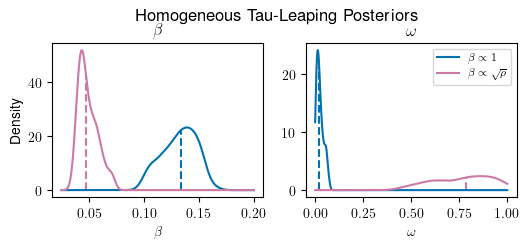

In [457]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6,2))
fig.suptitle('Homogeneous Tau-Leaping Posteriors',y=1.05)

ax1.vlines(np.median(shh1p1), 0, tau_1_p[0].pdf(np.median(shh1p1))[0], ls = '--', color = colors[0])
ax1.vlines(np.median(shh4p1), 0, tau_4_p[0].pdf(np.median(shh4p1))[0], ls = '--', color = colors[3])

ax1.plot(ep1, tau_1_p[0].pdf(ep1), label =  r"$\beta \not \propto \rho$", color = colors[0])
ax1.plot(ep1, tau_4_p[0].pdf(ep1), label =  r"$\beta \propto  \sqrt \rho$", color = colors[3])

ax1.set_title(r"$\beta$")
ax1.set_xlabel(r"$\beta$")
ax1.set_ylabel("Density")


ax2.vlines(np.median(shh1p2), 0, tau_1_p[1].pdf(np.median(shh1p2))[0], ls = '--', color = colors[0])
ax2.vlines(np.median(shh4p2), 0, tau_4_p[1].pdf(np.median(shh4p2))[0], ls = '--', color = colors[3])

ax2.plot(ep2, tau_1_p[1].pdf(ep2), label =  r"$\beta \propto 1$", color = colors[0])
ax2.plot(ep2, tau_4_p[1].pdf(ep2), label =  r"$\beta \propto  \sqrt \rho$", color = colors[3])

ax2.set_title(r"$\omega$")
ax2.set_xlabel(r"$\omega$")

ax2.legend(fontsize=8)
plt.savefig('tau_homogeneous_post.pdf', format='pdf', bbox_inches='tight')

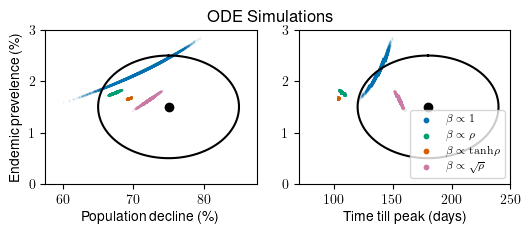

In [458]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6,2))
fig.suptitle('ODE Simulations')

ax1.scatter(ode_1[:,1], ode_1[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \not \propto \rho$")
ax1.scatter(ode_2[:,1], ode_2[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto \rho$")
ax1.scatter(ode_3[:,1], ode_3[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto \tanh{\rho}$")
ax1.scatter(ode_4[:,1], ode_4[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt{\rho}$")
    
u=1.5     #x-position of the center
v=75    #y-position of the center
a=1    #radius on the x-axis
b=10    #radius on the y-axis

ax1.plot(v,u,"ko")
t = np.linspace(0, 2*np.pi, 100)
ax1.plot( v+b*np.sin(t), u+a*np.cos(t) ,"k" )


ax2.scatter(ode_1[:,2], ode_1[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto 1$")
ax2.scatter(ode_2[:,2], ode_2[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto \rho$")
ax2.scatter(ode_3[:,2], ode_3[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto \tanh{\rho}$")
ax2.scatter(ode_4[:,2], ode_4[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt{\rho}$")

ax1.set_xlim([57.5,87.5])
ax1.set_ylim([0,3])

ax2.set_xlim([70,250])
ax2.set_ylim([0,3])

v = 180
b = 60

ax2.plot(v,u,"ko")
ax2.plot( v+b*np.sin(t), u+a*np.cos(t) ,"k" )

ax1.set_ylabel("Endemic prevelence (\%)")
ax1.set_xlabel("Population decline (\%)")
ax2.set_xlabel("Time till peak (days)")

lgnd = ax2.legend(loc=4, numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
plt.savefig('ode_sims.pdf', format='pdf', bbox_inches='tight')

In [ ]:
plt.scatter(ode_1[:,0], ode_1[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \not \propto \rho$")
plt.scatter(ode_2[:,0], ode_2[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \propto \rho$")
plt.scatter(ode_3[:,0], ode_3[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \propto \tanh{\rho}$")
plt.scatter(ode_4[:,0], ode_4[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt{\rho}$")
#plt.xlim([0,10])

In [103]:
tau_1_p = read_inputs("Posteriors/Tau-Homogeneous/", 1)
tau_2_p = read_inputs("Posteriors/Tau-Homogeneous/", 2)
tau_3_p = read_inputs("Posteriors/Tau-Homogeneous/", 3)
tau_4_p = read_inputs("Posteriors/Tau-Homogeneous/", 4)

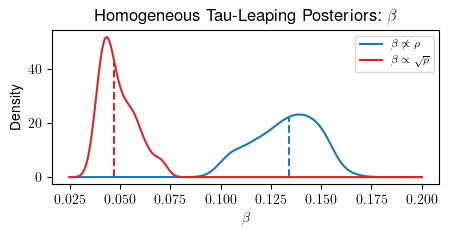

In [322]:
plt.figure(figsize=(5, 2))

plt.vlines(np.median(shh1p1), 0, tau_1_p[0].pdf(np.median(shh1p1))[0], ls = '--', color = colors[0])
#plt.vlines(np.median(shh2p1), 0, tau_2_p[0].pdf(np.median(shh2p1))[0], ls = '--', color = colors[1])
#plt.vlines(np.median(shh3p1), 0, tau_3_p[0].pdf(np.median(shh3p1))[0], ls = '--', color = colors[2])
plt.vlines(np.median(shh4p1), 0, tau_4_p[0].pdf(np.median(shh4p1))[0], ls = '--', color = colors[3])

plt.plot(ep1, tau_1_p[0].pdf(ep1), label =  r"$\beta \not \propto \rho$", color = colors[0])
#plt.plot(ep1, tau_2_p[0].pdf(ep1), label =  r"$\beta \propto \rho$", color = colors[1])
#plt.plot(ep1, tau_3_p[0].pdf(ep1), label =  r"$\beta \propto \tanh \rho$", color = colors[2])
plt.plot(ep1, tau_4_p[0].pdf(ep1), label =  r"$\beta \propto  \sqrt \rho$", color = colors[3])

plt.title(r"Homogeneous Tau-Leaping Posteriors: $\beta$")
plt.xlabel(r"$\beta$")
plt.ylabel("Density")
plt.legend(fontsize=8)
plt.savefig('tau_ho_beta.pdf', format='pdf', bbox_inches='tight')

In [109]:
n_samples = 1000000
shh1p2= tau_1_p[1].resample(n_samples)
shh2p2= tau_2_p[1].resample(n_samples)
shh3p2= tau_3_p[1].resample(n_samples)
shh4p2= tau_4_p[1].resample(n_samples)

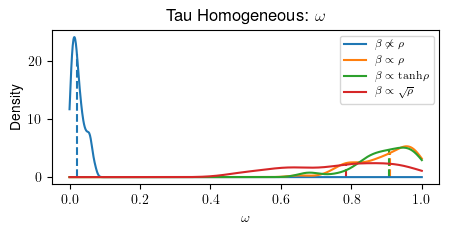

In [111]:
plt.figure(figsize=(5, 2))

plt.vlines(np.median(shh1p2), 0, tau_1_p[1].pdf(np.median(shh1p2))[0], ls = '--', color = colors[0])
plt.vlines(np.median(shh2p2), 0, tau_2_p[1].pdf(np.median(shh2p2))[0], ls = '--', color = colors[1])
plt.vlines(np.median(shh3p2), 0, tau_3_p[1].pdf(np.median(shh3p2))[0], ls = '--', color = colors[2])
plt.vlines(np.median(shh4p2), 0, tau_4_p[1].pdf(np.median(shh4p2))[0], ls = '--', color = colors[3])

plt.plot(ep2, tau_1_p[1].pdf(ep2), label =  r"$\beta \not \propto \rho$", color = colors[0])
plt.plot(ep2, tau_2_p[1].pdf(ep2), label =  r"$\beta \propto \rho$", color = colors[1])
plt.plot(ep2, tau_3_p[1].pdf(ep2), label =  r"$\beta \propto \tanh \rho$", color = colors[2])
plt.plot(ep2, tau_4_p[1].pdf(ep2), label =  r"$\beta \propto  \sqrt \rho$", color = colors[3])

plt.title(r"Tau Homogeneous: $\omega$")
plt.xlabel(r"$\omega$")
plt.ylabel("Density")
plt.legend(fontsize=8)
plt.savefig('tau_ho_omega.pdf', format='pdf', bbox_inches='tight')

## Scale Free

In [166]:
tausf_1, sfd1 = run_simulations("Posteriors/Tau-Hetrogeneous/Scale_Free/", 1, 250)
tausf_4, sfd4 = run_simulations("Posteriors/Tau-Hetrogeneous/Scale_Free/", 4, 250)

Finished
Finished


In [168]:
tausf_1f  = tausf_1[tausf_1[:,0] > 0]
tausf_4f  = tausf_4[tausf_4[:,0] > 0]


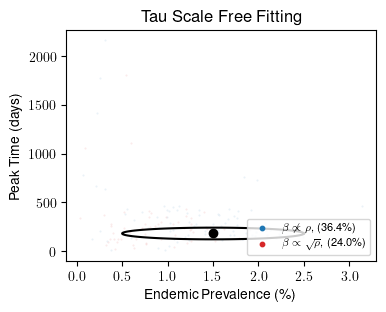

In [169]:
plt.figure(figsize=(4, 3))

plt.scatter(tausf_1f[:,0], tausf_1f[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \not \propto \rho$, ({}\%)".format(round(100*sfd1/len(tausf_1),1)), color = colors[0])
plt.scatter(tausf_4f[:,0], tausf_4f[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt \rho$, ({}\%)".format(round(100*sfd4/len(tausf_4),1)), color = colors[3])
#plt.ylim([0,100])

lgnd = plt.legend(loc="lower right", numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    

u=1.5     #x-position of the center
v=180    #y-position of the center
a=1    #radius on the x-axis
b=60    #radius on the y-axis

plt.plot(u,v,"ko")

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), "k" )
    
plt.xlabel(r"Endemic Prevalence (\%)")
plt.ylabel("Peak Time (days)")

plt.title("Tau Scale Free Fitting")
plt.savefig('tausfcomp01.pdf', format='pdf', bbox_inches='tight')

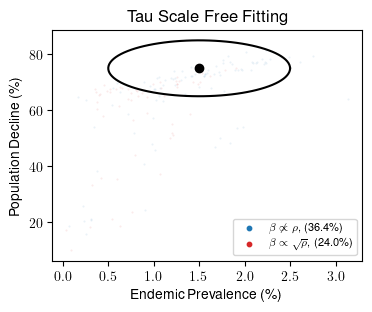

In [170]:
plt.figure(figsize=(4, 3))

plt.scatter(tausf_1f[:,0], tausf_1f[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \not \propto \rho$, ({}\%)".format(round(100*sfd1/len(tausf_1),1)), color = colors[0])
plt.scatter(tausf_4f[:,0], tausf_4f[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt \rho$, ({}\%)".format(round(100*sfd4/len(tausf_4),1)), color = colors[3])
#plt.ylim([0,100])

lgnd = plt.legend(loc="lower right", numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
u=1.5     #x-position of the center
v=75    #y-position of the center
a=1    #radius on the x-axis
b=10    #radius on the y-axis

plt.plot(u,v,"ko")

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), "k" )
    
plt.xlabel(r"Endemic Prevalence (\%)")
plt.ylabel(r"Population Decline (\%)")
plt.title("Tau Scale Free Fitting")
plt.savefig('tausfcomp01.pdf', format='pdf', bbox_inches='tight')

In [197]:
tau_sf_1_p = read_inputs("Posteriors/Tau-Hetrogeneous/Scale_Free/",1)
tau_sf_4_p = read_inputs("Posteriors/Tau-Hetrogeneous/Scale_Free/",4)

tau_r_1_p = read_inputs("Posteriors/Tau-Hetrogeneous/Random/",1)
tau_r_4_p = read_inputs("Posteriors/Tau-Hetrogeneous/Random/",4)

tau_sw_1_p = read_inputs("Posteriors/Tau-Hetrogeneous/Small_Worlds/",1)
tau_sw_4_p = read_inputs("Posteriors/Tau-Hetrogeneous/Small_Worlds/",4)

In [249]:
data = tau_sf_4_p

beta1 = data[0].pdf(x)
beta2 = data[1].pdf(x)
beta3 = data[2].pdf(x)

print(np.round(x[np.argmax(beta1)],3))
print(np.round(x[np.argmax(beta2)],3))
print(np.round(x[np.argmax(beta3)],3))

0.173
0.03
0.348


In [460]:
ep1 = np.linspace(0, 1, 1000)
ep2 = np.linspace(0, 0.3, 1000)
ep3 = np.linspace(0, 1, 1000)

n_samples = 1000000

In [188]:
sf1p1= tau_sf_1_p[0].resample(n_samples)
sf4p1= tau_sf_4_p[0].resample(n_samples)

sf1p2= tau_sf_1_p[1].resample(n_samples)
sf4p2= tau_sf_4_p[1].resample(n_samples)

sf1p3= tau_sf_1_p[2].resample(n_samples)
sf4p3= tau_sf_4_p[2].resample(n_samples)



In [198]:
r1p1= tau_r_1_p[0].resample(n_samples)
r4p1= tau_r_4_p[0].resample(n_samples)

r1p2= tau_r_1_p[1].resample(n_samples)
r4p2= tau_r_4_p[1].resample(n_samples)

r1p3= tau_r_1_p[2].resample(n_samples)
r4p3= tau_r_4_p[2].resample(n_samples)


In [199]:
sw1p1= tau_sw_1_p[0].resample(n_samples)
sw4p1= tau_sw_4_p[0].resample(n_samples)

sw1p2= tau_sw_1_p[1].resample(n_samples)
sw4p2= tau_sw_4_p[1].resample(n_samples)

sw1p3= tau_sw_1_p[2].resample(n_samples)
sw4p3= tau_sw_4_p[2].resample(n_samples)


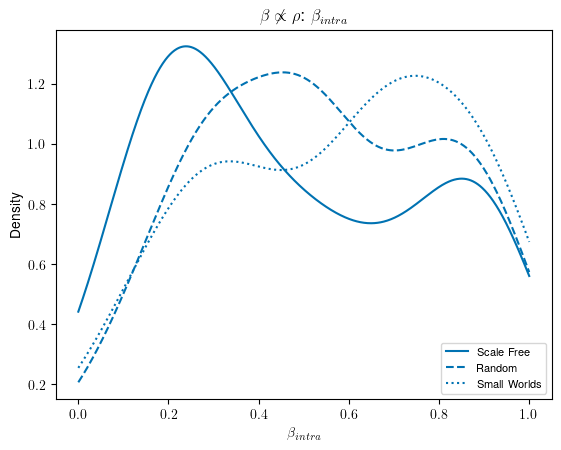

In [416]:
x = np.linspace(0, 1, 100000)

plt.plot(ep1, tau_sf_1_p[0].pdf(ep1), label =  r"Scale Free", color = colors[0])
plt.plot(ep1, tau_r_1_p[0].pdf(ep1), label =  r"Random", color = colors[0], ls = '--')
plt.plot(ep1, tau_sw_1_p[0].pdf(ep1), label =  r"Small Worlds", color = colors[0], ls = ":")


plt.title(r"$\beta \not \propto \rho$: $\beta_{intra}$")
plt.xlabel(r"$\beta_{intra}$")
plt.ylabel("Density")
plt.legend(fontsize=8)

In [ ]:
data

In [241]:
print_result(sw4p1)
print_result(sw4p2)
print_result(sw4p3)

0.63
0.663
0.047
0.044
0.667
0.686


In [440]:
import matplotlib

In [445]:
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

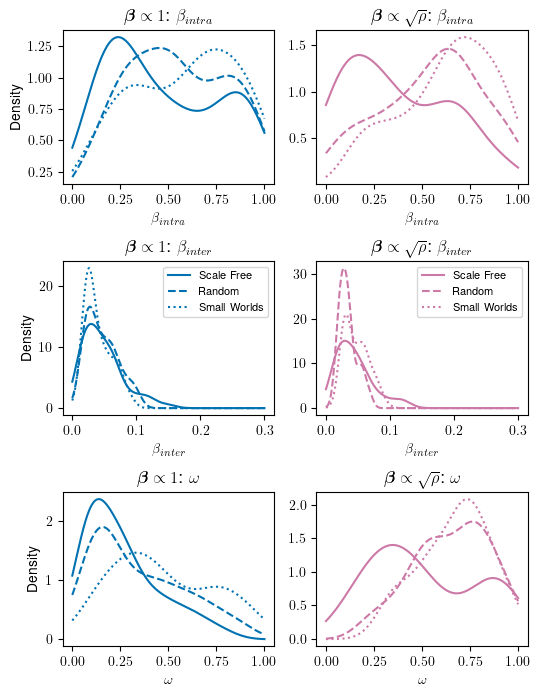

In [461]:
fig = plt.figure(figsize=(6,8))

gs = GridSpec(3, 2, figure=fig, hspace=.5)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])


ax1.plot(ep1, tau_sf_1_p[0].pdf(ep1), label =  r"Scale Free", color = colors[0])
ax1.plot(ep1, tau_r_1_p[0].pdf(ep1), label =  r"Random", color = colors[0], ls = '--')
ax1.plot(ep1, tau_sw_1_p[0].pdf(ep1), label =  r"Small Worlds", color = colors[0], ls = ":")

ax2.plot(ep1, tau_sf_4_p[0].pdf(ep1), label =  r"Scale Free", color = colors[3])
ax2.plot(ep1, tau_r_4_p[0].pdf(ep1), label =  r"Random", color = colors[3], ls="--")
ax2.plot(ep1, tau_sw_4_p[0].pdf(ep1), label =  r"Small Worlds", color = colors[3], ls=":")


ax3.plot(ep2, tau_sf_1_p[1].pdf(ep2), label =  r"Scale Free", color = colors[0])
ax3.plot(ep2, tau_r_1_p[1].pdf(ep2), label =  r"Random", color = colors[0], ls = '--')
ax3.plot(ep2, tau_sw_1_p[1].pdf(ep2), label =  r"Small Worlds", color = colors[0], ls = ":")

ax3.legend(fontsize=8)

ax4.plot(ep2, tau_sf_4_p[1].pdf(ep2), label =  r"Scale Free", color = colors[3])
ax4.plot(ep2, tau_r_4_p[1].pdf(ep2), label =  r"Random", color = colors[3], ls="--")
ax4.plot(ep2, tau_sw_4_p[1].pdf(ep2), label =  r"Small Worlds", color = colors[3], ls=":")

ax4.legend(fontsize=8)



ax5.plot(ep3, tau_sf_1_p[2].pdf(ep3), label =  r"Scale Free", color = colors[0])
ax5.plot(ep3, tau_r_1_p[2].pdf(ep3), label =  r"Random", color = colors[0], ls = '--')
ax5.plot(ep3, tau_sw_1_p[2].pdf(ep3), label =  r"Small Worlds", color = colors[0], ls = ":")

ax6.plot(ep3, tau_sf_4_p[2].pdf(ep3), label =  r"Scale Free", color = colors[3])
ax6.plot(ep3, tau_r_4_p[2].pdf(ep3), label =  r"Random", color = colors[3], ls="--")
ax6.plot(ep3, tau_sw_4_p[2].pdf(ep3), label =  r"Small Worlds", color = colors[3], ls=":")

ax1.set_ylabel("Density")
ax3.set_ylabel("Density")
ax5.set_ylabel("Density")

ax1.set_xlabel(r"$\beta_{intra}$")
ax2.set_xlabel(r"$\beta_{intra}$")

ax3.set_xlabel(r"$\beta_{inter}$")
ax4.set_xlabel(r"$\beta_{inter}$")


ax5.set_xlabel(r"$\omega$")
ax6.set_xlabel(r"$\omega$")

ax1.set_title(r"$\boldsymbol{\beta}\propto 1$: $\beta_{intra}$")
ax3.set_title(r"$\boldsymbol{\beta}\propto 1$: $\beta_{inter}$")
ax5.set_title(r"$\boldsymbol{\beta}\propto 1$: $\omega$")

ax2.set_title(r"$\boldsymbol{\beta}\propto \sqrt \rho$: $\beta_{intra}$")
ax4.set_title(r"$\boldsymbol{\beta}\propto \sqrt \rho$: $\beta_{inter}$")
ax6.set_title(r"$\boldsymbol{\beta}\propto \sqrt \rho$: $\omega$")

plt.savefig('tau_hetrogeneous_post.pdf', format='pdf', bbox_inches='tight')

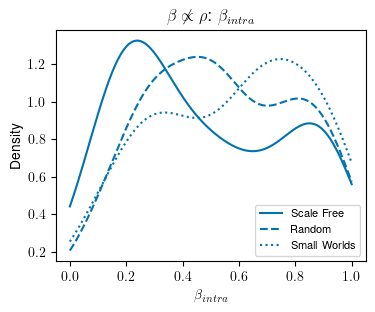

In [405]:
plt.figure(figsize=(4, 3))

plt.plot(ep1, tau_sf_1_p[0].pdf(ep1), label =  r"Scale Free", color = colors[0])
plt.plot(ep1, tau_r_1_p[0].pdf(ep1), label =  r"Random", color = colors[0], ls = '--')
plt.plot(ep1, tau_sw_1_p[0].pdf(ep1), label =  r"Small Worlds", color = colors[0], ls = ":")


plt.title(r"$\beta \not \propto \rho$: $\beta_{intra}$")
plt.xlabel(r"$\beta_{intra}$")
plt.ylabel("Density")
plt.legend(fontsize=8)
plt.savefig('tau_nr_beta1.pdf', format='pdf', bbox_inches='tight')

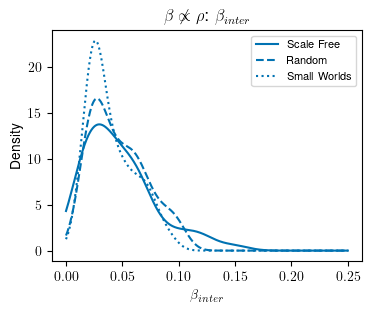

In [407]:

plt.figure(figsize=(4, 3))
plt.plot(ep2, tau_sf_1_p[1].pdf(ep2), label =  r"Scale Free", color = colors[0])
plt.plot(ep2, tau_r_1_p[1].pdf(ep2), label =  r"Random", color = colors[0], ls ="--")
plt.plot(ep2, tau_sw_1_p[1].pdf(ep2), label =  r"Small Worlds", color = colors[0], ls= ":")


plt.title(r"$\beta \not \propto \rho$: $\beta_{inter}$")
plt.xlabel(r"$\beta_{inter}$")
plt.ylabel("Density")
plt.legend(fontsize=8)

plt.savefig('tau_nr_beta2.pdf', format='pdf', bbox_inches='tight')

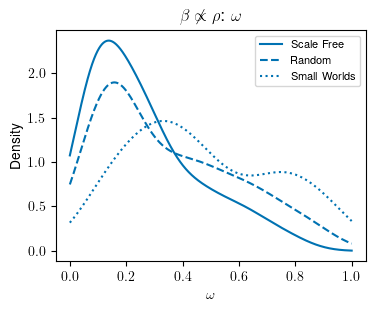

In [409]:
plt.figure(figsize=(4, 3))
plt.plot(ep3, tau_sf_1_p[2].pdf(ep3), label =  r"Scale Free", color = colors[0])
plt.plot(ep3, tau_r_1_p[2].pdf(ep3), label =  r"Random", color = colors[0], ls = "--")
plt.plot(ep3, tau_sw_1_p[2].pdf(ep3), label =  r"Small Worlds", color = colors[0], ls= ":")


plt.title(r"$\beta \not \propto \rho$: $\omega$")
plt.xlabel(r"$\omega$")
plt.ylabel("Density")
plt.legend(fontsize=8)

plt.savefig('tau_nr_omega.pdf', format='pdf', bbox_inches='tight')

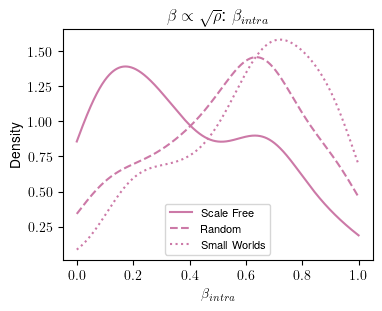

In [410]:
plt.figure(figsize=(4, 3))
plt.plot(ep1, tau_sf_4_p[0].pdf(ep1), label =  r"Scale Free", color = colors[3])
plt.plot(ep1, tau_r_4_p[0].pdf(ep1), label =  r"Random", color = colors[3], ls="--")
plt.plot(ep1, tau_sw_4_p[0].pdf(ep1), label =  r"Small Worlds", color = colors[3], ls=":")


plt.title(r"$\beta \propto \sqrt \rho$: $\beta_{intra}$")
plt.xlabel(r"$\beta_{intra}$")
plt.ylabel("Density")
plt.legend(fontsize=8)

plt.savefig('tau_sqrt_beta1.pdf', format='pdf', bbox_inches='tight')

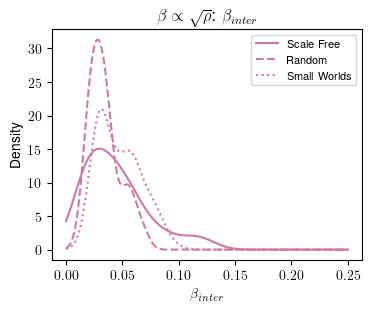

In [412]:
plt.figure(figsize=(4, 3))
plt.plot(ep2, tau_sf_4_p[1].pdf(ep2), label =  r"Scale Free", color = colors[3])
plt.plot(ep2, tau_r_4_p[1].pdf(ep2), label =  r"Random", color = colors[3], ls="--")
plt.plot(ep2, tau_sw_4_p[1].pdf(ep2), label =  r"Small Worlds", color = colors[3], ls=":")


plt.title(r"$\beta \propto \sqrt \rho$: $\beta_{inter}$")
plt.xlabel(r"$\beta_{inter}$")
plt.ylabel("Density")
plt.legend(fontsize=8)

plt.savefig('tau_sqrt_beta2.pdf', format='pdf', bbox_inches='tight')

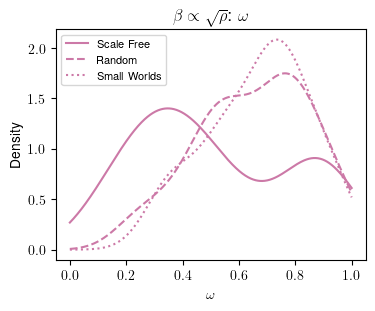

In [413]:
plt.figure(figsize=(4, 3))
plt.plot(ep3, tau_sf_4_p[2].pdf(ep3), label =  r"Scale Free", color = colors[3], ls="-")
plt.plot(ep3, tau_r_4_p[2].pdf(ep3), label =  r"Random", color = colors[3], ls="--")
plt.plot(ep3, tau_sw_4_p[2].pdf(ep3), label =  r"Small Worlds", color = colors[3], ls=":")


plt.title(r"$\beta \propto \sqrt \rho$: $\omega$")
plt.xlabel(r"$\omega$")
plt.ylabel("Density")
plt.legend(fontsize=8)

plt.savefig('tau_sqrt_omega.pdf', format='pdf', bbox_inches='tight')

# Fitting ODE model and deciding best!

In [10]:
jl.eval('push!(LOAD_PATH, "/home/callum/ASF/Fitting/ODE_FIT.jl")')
jl.include('/home/callum/ASF/Fitting/ODE_FIT.jl') #loading files with our model!

<PyCall.jlwrap Main.SIR_ODE>

In [13]:
#Loading the four models!
model1 = jl.SIR_ODE.model_1 #Frequency
model2 = jl.SIR_ODE.model_2 #Pure Density
model3 = jl.SIR_ODE.model_3 #Sigmoid Density
model4 = jl.SIR_ODE.model_4 #Sqrt Density

models  =[model1,model2,model3,model4]

/home/callum/.local/lib/python3.10/site-packages/julia/core.py:709: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


In [12]:
#The observations!
obs = jl.SIR_ODE.observation

#Distance function used for fitting
distance = jl.SIR_ODE.distance


In [ ]:
#Fitting two params P1 - transmission co-efficent, P2 - corpse infectivity modifier
parameter_prior = Distribution(p1=RV("uniform", 0.0, 1.0),p2=RV("uniform", 0.0, 1.0))

#sample params to test functions all work and pre-compile
sample_par = {"p1": 0.1,"p2": 0.5} 

n = 4 #number of models we are looking at!
param_list = [parameter_prior]*n

In [ ]:
distance(model1(sample_par),obs)
distance(model2(sample_par),obs)
distance(model3(sample_par),obs)
distance(model4(sample_par),obs);

In [ ]:
abc= ABCSMC(
    models=model4,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size =  AdaptivePopulationSize(1000, 0.15,max_population_size = 1000),
    sampler = SingleCoreSampler(),
)



In [ ]:
abc_id = abc.new("sqlite:////tmp/mp.db", obs)


In [ ]:
h4 = abc.run(minimum_epsilon=0.5,max_nr_populations=20)


In [ ]:
plt.figure(figsize=(4, 3))

plt.scatter(out1_ode[:,0], out1_ode[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \not \propto \rho$")
plt.scatter(out2_ode[:,0], out2_ode[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \propto \rho$")
plt.scatter(out3_ode[:,0], out3_ode[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \propto \tanh{\rho}$")
plt.scatter(out4_ode[:,0], out4_ode[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt{\rho}$")
#plt.xlim([0,10])
#plt.ylim([0,100])

lgnd = plt.legend(loc="upper right", numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
u=1.5     #x-position of the center
v=180    #y-position of the center
a=1    #radius on the x-axis
b=60    #radius on the y-axis

plt.plot(u,v,"ko")

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), "k" )
    
plt.xlabel(r"Endemic Prevalence (\%)")
plt.ylabel("Peak Time (days)")
plt.title("ODE Fitting")

plt.savefig('odecomp02.pdf', format='pdf', bbox_inches='tight')

In [ ]:
out1_tau = run_sim(h1_h,1000,model1_h)
out2_tau = run_sim(h2_h,1000,model2_h)
out3_tau = run_sim(h3_h,1000,model3_h)
out4_tau = run_sim(h4_h,1000,model4_h)

In [ ]:
filter_1 = out1_tau[out1_tau[:,0] > 0.25]
filter_2 = out2_tau[out2_tau[:,0] > 0.25]
filter_3 = out3_tau[out3_tau[:,0] > 0.25]
filter_4 = out4_tau[out4_tau[:,0] > 0.25]

filter_m1 = filter_1[filter_1[:,2]< 360]
filter_m2 = filter_2[filter_2[:,2]< 360]
filter_m3 = filter_3[filter_3[:,2]< 360]
filter_m4 = filter_4[filter_4[:,2]< 360]

In [ ]:
plt.figure(figsize=(4, 3))

plt.scatter(filter_m1[:,0], filter_m1[:,1], s = 0.3, alpha=0.2, label =  r"$\beta \not \propto \rho$ ({}\% Filtered)".format(round(100-100*len(filter_m1)/len(out1_tau),1)))
plt.scatter(filter_m2[:,0], filter_m2[:,1], s = 0.3, alpha=0.2, label =  r"$\beta \propto \rho$ ({}\% Filtered)".format(round(100-100*len(filter_m2)/len(out2_tau),1)))
plt.scatter(filter_m3[:,0], filter_m3[:,1], s = 0.3, alpha=0.2, label =  r"$\beta \propto \tanh\rho$ ({}\% Filtered)".format(round(100-100*len(filter_m3)/len(out3_tau),1)))
plt.scatter(filter_m4[:,0], filter_m4[:,1], s = 0.3, alpha=0.2, label =  r"$\beta \propto \sqrt\rho$ ({}\% Filtered)".format(round(100-100*len(filter_m4)/len(out4_tau),1)))
plt.xlim([0,5])
plt.ylim([40,100])

lgnd = plt.legend(loc="lower right", numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
u=1.5     #x-position of the center
v=75    #y-position of the center
a=1    #radius on the x-axis
b=10    #radius on the y-axis

plt.plot(u,v,"ko")

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), "k" )
    
plt.xlabel(r"Endemic Prevalence (\%)")
plt.ylabel(r"Population Decline (\%)")
plt.title("Tau Homogeneous Fitting")
plt.savefig('taucomp02z.pdf', format='pdf', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(4, 3))

plt.scatter(filter_m1[:,0], filter_m1[:,1], s = 0.3, alpha=0.2, label =  r"$\beta \not \propto \rho$ ({}\% Filtered)".format(round(100-100*len(filter_m1)/len(out1_tau),1)))
plt.scatter(filter_m2[:,0], filter_m2[:,1], s = 0.3, alpha=0.2, label =  r"$\beta \propto \rho$ ({}\% Filtered)".format(round(100-100*len(filter_m2)/len(out2_tau),1)))
plt.scatter(filter_m3[:,0], filter_m3[:,1], s = 0.3, alpha=0.2, label =  r"$\beta \propto \tanh\rho$ ({}\% Filtered)".format(round(100-100*len(filter_m3)/len(out3_tau),1)))
plt.scatter(filter_m4[:,0], filter_m4[:,1], s = 0.3, alpha=0.2, label =  r"$\beta \propto \sqrt\rho$ ({}\% Filtered)".format(round(100-100*len(filter_m4)/len(out4_tau),1)))
plt.xlim([0,5])
plt.ylim([40,100])

lgnd = plt.legend(loc="lower right", numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
u=1.5     #x-position of the center
v=75    #y-position of the center
a=1    #radius on the x-axis
b=10    #radius on the y-axis

plt.plot(u,v,"ko")

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), "k" )
    
plt.xlabel(r"Endemic Prevalence (\%)")
plt.ylabel(r"Population Decline (\%)")
plt.title("Tau Homogeneous Fitting")
plt.savefig('taucomp02z.pdf', format='pdf', bbox_inches='tight')

In [38]:
filter_1 = out1_taun[out1_taun[:,0] > 0.2]
filter_4 = out4_taun[out4_taun[:,0] > 0.2]

filter_m1 = filter_1[filter_1[:,2]< 360]
filter_m4 = filter_4[filter_4[:,2]< 360]

Text(0.5, 1.0, 'Tau Hetrogeneous Scale Free Fitting')

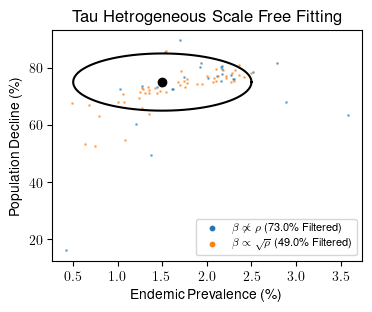

In [39]:
plt.figure(figsize=(4, 3))

plt.scatter(filter_m1[:,0], filter_m1[:,1], s = 1, alpha=0.5, label =  r"$\beta \not \propto \rho$ ({}\% Filtered)".format(round(100-100*len(filter_m1)/len(out1_taun),1)))
plt.scatter(filter_m4[:,0], filter_m4[:,1], s = 1, alpha=0.5, label =  r"$\beta \propto \sqrt\rho$ ({}\% Filtered)".format(round(100-100*len(filter_m4)/len(out4_taun),1)))
#plt.xlim([0,5])
#plt.ylim([40,100])

lgnd = plt.legend(loc="lower right", numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
u=1.5     #x-position of the center
v=75    #y-position of the center
a=1    #radius on the x-axis
b=10    #radius on the y-axis

plt.plot(u,v,"ko")

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), "k" )
    
plt.xlabel(r"Endemic Prevalence (\%)")
plt.ylabel(r"Population Decline (\%)")
plt.title("Tau Hetrogeneous Scale Free Fitting")
#plt.savefig('taucomp02z.pdf', format='pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Tau Hetrogeneous Scale Free Fitting')

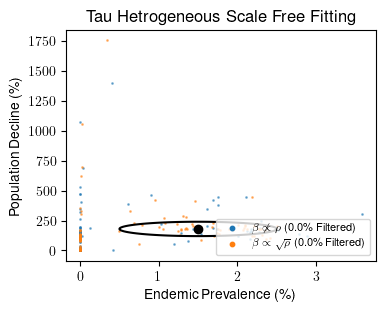

In [36]:
plt.figure(figsize=(4, 3))

plt.scatter(out1_taun[:,0], out1_taun[:,2], s = 1, alpha=0.5, label =  r"$\beta \not \propto \rho$ ({}\% Filtered)".format(round(100-100*len(out1_taun)/len(out1_taun),1)))
#plt.scatter(filter_m2[:,0], filter_m2[:,1], s = 0.3, alpha=0.2, label =  r"$\beta \propto \rho$ ({}\% Filtered)".format(round(100-100*len(filter_m2)/len(out2_tau),1)))
#plt.scatter(filter_m3[:,0], filter_m3[:,1], s = 0.3, alpha=0.2, label =  r"$\beta \propto \tanh\rho$ ({}\% Filtered)".format(round(100-100*len(filter_m3)/len(out3_tau),1)))
plt.scatter(out4_taun[:,0], out4_taun[:,2], s = 1, alpha=0.5, label =  r"$\beta \propto \sqrt\rho$ ({}\% Filtered)".format(round(100-100*len(out1_taun)/len(out1_taun),1)))


lgnd = plt.legend(loc="lower right", numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
u=1.5     #x-position of the center
v=180    #y-position of the center
a=1    #radius on the x-axis
b=60    #radius on the y-axis

plt.plot(u,v,"ko")

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), "k" )
    
plt.xlabel(r"Endemic Prevalence (\%)")
plt.ylabel(r"Population Decline (\%)")
plt.title("Tau Hetrogeneous Scale Free Fitting")

In [ ]:
h1_p1, h1_p2 = distri(h1)
h2_p1, h2_p2 = distri(h2)
h3_p1, h3_p2 = distri(h3)
h4_p1, h4_p2 = distri(h4)

hh1_p1, hh1_p2 = distri(h1_h)
hh2_p1, hh2_p2 = distri(h2_h)
hh3_p1, hh3_p2 = distri(h3_h)
hh4_p1, hh4_p2 = distri(h4_h)

In [ ]:
np.savetxt("h1_weights.csv", h1.get_distribution(t=24)[1], delimiter=",")
np.savetxt("h1_params.csv", h1.get_distribution(t=24)[0].values, delimiter=",")

np.savetxt("h2_weights.csv", h2.get_distribution(t=19)[1], delimiter=",")
np.savetxt("h2_params.csv", h2.get_distribution(t=19)[0].values, delimiter=",")

np.savetxt("h3_weights.csv", h3.get_distribution(t=19)[1], delimiter=",")
np.savetxt("h3_params.csv", h3.get_distribution(t=19)[0].values, delimiter=",")

np.savetxt("h4_weights.csv", h4.get_distribution(t=19)[1], delimiter=",")
np.savetxt("h4_params.csv", h4.get_distribution(t=19)[0].values, delimiter=",")


In [ ]:
np.savetxt("gh1_weights.csv", h1_h.get_distribution(t=14)[1], delimiter=",")
np.savetxt("gh1_params.csv", h1_h.get_distribution(t=14)[0].values, delimiter=",")

np.savetxt("gh2_weights.csv", h2_h.get_distribution(t=14)[1], delimiter=",")
np.savetxt("gh2_params.csv", h2_h.get_distribution(t=14)[0].values, delimiter=",")

np.savetxt("gh3_weights.csv", h3_h.get_distribution(t=14)[1], delimiter=",")
np.savetxt("gh3_params.csv", h3_h.get_distribution(t=14)[0].values, delimiter=",")

np.savetxt("gh4_weights.csv", h4_h.get_distribution(t=14)[1], delimiter=",")
np.savetxt("gh4_params.csv", h4_h.get_distribution(t=14)[0].values, delimiter=",")


In [ ]:
h4_h.get_distribution(t=14)

In [ ]:
h4.get_distribution(t=19)[0].values

In [ ]:
h1.get_distribution(t=24)[1]

In [ ]:
ep1 = np.linspace(0.025, 0.15, 1000)
ep2 = np.linspace(0, 1, 1000)

In [ ]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [ ]:
ep1 = np.linspace(0.025, 0.15, 1000)
ep2 = np.linspace(0, 1, 1000)

n_samples = 1000000
shh1p1= hh1_p1.resample(n_samples)
shh2p1= hh2_p1.resample(n_samples)
shh3p1= hh3_p1.resample(n_samples)
shh4p1= hh4_p1.resample(n_samples)

In [ ]:
plt.figure(figsize=(5, 2))

plt.vlines(np.median(shh1p1), 0, hh1_p1.pdf(np.median(shh1p1))[0], ls = '--', color = colors[0])
plt.vlines(np.median(shh2p1), 0, hh2_p1.pdf(np.median(shh2p1))[0], ls = '--', color = colors[1])
plt.vlines(np.median(shh3p1), 0, hh3_p1.pdf(np.median(shh3p1))[0], ls = '--', color = colors[2])
plt.vlines(np.median(shh4p1), 0, hh4_p1.pdf(np.median(shh4p1))[0], ls = '--', color = colors[3])

plt.plot(ep1, hh1_p1.pdf(ep1), label =  r"$\beta \not \propto \rho$", color = colors[0])
plt.plot(ep1, hh2_p1.pdf(ep1), label =  r"$\beta \propto \rho$", color = colors[1])
plt.plot(ep1, hh3_p1.pdf(ep1), label =  r"$\beta \propto \tanh \rho$", color = colors[2])
plt.plot(ep1, hh4_p1.pdf(ep1), label =  r"$\beta \propto  \sqrt \rho$", color = colors[3])

plt.title(r"Tau Homogeneous: $\beta$")
plt.xlabel(r"$\beta$")
plt.ylabel("Density")
plt.legend(fontsize=8)
plt.savefig('tau_ho_beta.pdf', format='pdf', bbox_inches='tight')

In [ ]:
n_samples = 1000000
shh1p2= hh1_p2.resample(n_samples)
shh2p2= hh2_p2.resample(n_samples)
shh3p2= hh3_p2.resample(n_samples)
shh4p2= hh4_p2.resample(n_samples)

In [ ]:
plt.figure(figsize=(5, 2))

plt.vlines(np.median(shh1p2), 0, hh1_p2.pdf(np.median(shh1p2))[0], ls = '--', color = colors[0])
plt.vlines(np.median(shh2p2), 0, hh2_p2.pdf(np.median(shh2p2))[0], ls = '--', color = colors[1])
plt.vlines(np.median(shh3p2), 0, hh3_p2.pdf(np.median(shh3p2))[0], ls = '--', color = colors[2])
plt.vlines(np.median(shh4p2), 0, hh4_p2.pdf(np.median(shh4p2))[0], ls = '--', color = colors[3])


plt.plot(ep2, hh1_p2.pdf(ep2), label =  r"$\beta \not \propto \rho$", color = colors[0])
plt.plot(ep2, hh2_p2.pdf(ep2), label =  r"$\beta \propto \rho$", color = colors[1])
plt.plot(ep2, hh3_p2.pdf(ep2), label =  r"$\beta \propto \tanh \rho$", color = colors[2])
plt.plot(ep2, hh4_p2.pdf(ep2), label =  r"$\beta \propto  \sqrt \rho$", color = colors[3])

plt.title(r"Tau Homogeneous: $\omega$")
plt.xlabel(r"$\omega$")
plt.ylabel("Density")
plt.legend(fontsize=8)
plt.savefig('tau_ho_omega.pdf', format='pdf', bbox_inches='tight')

In [ ]:
import matplotlib

In [ ]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [ ]:
n_samples = 1000000
sh1p2= h1_p2.resample(n_samples)
sh2p2= h2_p2.resample(n_samples)
sh3p2= h3_p2.resample(n_samples)
sh4p2= h4_p2.resample(n_samples)

In [ ]:
for ax in bax.axs:
    fmt = matplotlib.ticker.StrMethodFormatter("{x:g}")
    ax.xaxis.set_major_formatter(fmt)
    ax.yaxis.set_major_formatter(fmt)


In [ ]:
3

In [ ]:
x = np.linspace(0,1,10000)
x[500:] = np.linspace(0.95,1.0,9500)



f,(ax,ax2) = plt.subplots(1,2,sharey=True, facecolor='w')

# plot the same data on both axes
ax.plot(x, h1_p2.pdf(x))
ax2.plot(x, h1_p2.pdf(x))


ax.plot(x, h2_p2.pdf(x))
ax2.plot(x, h2_p2.pdf(x))

ax.plot(x, h3_p2.pdf(x))
ax2.plot(x, h3_p2.pdf(x))

ax.plot(x, h4_p2.pdf(x))
ax2.plot(x, h4_p2.pdf(x))

#plt.plot(ep2[0:500], h1_p2.pdf(ep2[0:500]))

ax.set_xlim(0,0.025)
ax2.set_xlim(0.975,1.0)

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.tick_params(labelright='on')

# don't put tick labels at the top
# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

plt.show()

In [ ]:
ep1 = np.linspace(0.01, 0.25, 1000)

In [ ]:
plt.plot(ep1, hh1_p1.pdf(ep1), label = "1")
plt.plot(ep1, hh2_p1.pdf(ep1), label = "2")
plt.plot(ep1, hh3_p1.pdf(ep1), label = "3")
plt.plot(ep1, hh4_p1.pdf(ep1), label = "4")
plt.title("Param 1")
plt.legend()

In [ ]:
plt.plot(ep2, hh1_p2.pdf(ep2), label = "1")
plt.plot(ep2, hh2_p2.pdf(ep2), label = "2")
plt.plot(ep2, hh3_p2.pdf(ep2), label = "3")
plt.plot(ep2, hh4_p2.pdf(ep2), label = "4")
plt.title("Param 2")
plt.legend()

In [ ]:
filter_m1 = filter_1[filter_1[:,2]< 360]
filter_m2 = filter_2[filter_2[:,2]< 360]
filter_m3 = filter_3[filter_3[:,2]< 360]
filter_m4 = filter_4[filter_4[:,2]< 360]

In [ ]:
plt.scatter(filter_m1[:,0], filter_m1[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \not \propto \rho$ ({}\% Filtered)".format(round(100-100*len(filter_m1)/len(out1_tau),1)))
plt.scatter(filter_m2[:,0], filter_m2[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \propto \rho$ ({}\% Filtered)".format(round(100-100*len(filter_m2)/len(out2_tau),1)))
plt.scatter(filter_m3[:,0], filter_m3[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \propto \tanh\rho$ ({}\% Filtered)".format(round(100-100*len(filter_m3)/len(out3_tau),1)))
plt.scatter(filter_m4[:,0], filter_m4[:,2], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt\rho$ ({}\% Filtered)".format(round(100-100*len(filter_m4)/len(out4_tau),1)))


lgnd = plt.legend(loc="lower right", numpoints=1, fontsize=10)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
u=1.5     #x-position of the center
v=180    #y-position of the center
a=1    #radius on the x-axis
b=60    #radius on the y-axis

plt.plot(u,v,"ko")

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), "k" )
    
plt.xlabel(r"Endemic Prevalence (\%)")
plt.ylabel(r"Population Decline (\%)")
plt.title("Tau Homogeneous Fitting")


In [ ]:
plt.scatter(filter_m1[:,0], filter_m1[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \not \propto \rho$ ({}\% Filtered)".format(round(100-100*len(filter_m1)/len(out1_tau),1)))
plt.scatter(filter_m4[:,0], filter_m4[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt\rho$ ({}\% Filtered)".format(round(100-100*len(filter_m4)/len(out4_tau),1)))


plt.scatter(out1_ode[:,0], out1_ode[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \not \propto \rho$")
plt.scatter(out4_ode[:,0], out4_ode[:,1], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt\rho$ ")


lgnd = plt.legend(loc="lower right", numpoints=1, fontsize=10)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
u=1.5     #x-position of the center
v=75    #y-position of the center
a=1    #radius on the x-axis
b=10    #radius on the y-axis

plt.plot(u,v,"ko")

t = np.linspace(0, 2*np.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), "k" )
    
plt.xlabel(r"Endemic Prevalence (\%)")
plt.ylabel(r"Population Decline (\%)")
plt.title("Tau Homogeneous Fitting")


# Tau Leaping Homogeneous 

In [161]:
jl.eval('push!(LOAD_PATH, "/home/callum/ASF/Fitting/TAU_HOMO_FIT.jl")')
jl.include('/home/callum/ASF/Fitting/TAU_HOMO_FIT.jl') #loading files with our model!

<PyCall.jlwrap Main.SIR_TAU_S>

In [162]:
model1 = jl.SIR_TAU_S.model_1 #Frequency
model2 = jl.SIR_TAU_S.model_2 #Pure Density
model3 = jl.SIR_TAU_S.model_3 #Sigmoid Density
model4 = jl.SIR_TAU_S.model_4 #Sqrt Density

#models_h  =[model1_h,model2_h,model3_h,model4_h]

In [ ]:
distance(model1_h (sample_par),obs)
distance(model2_h (sample_par),obs)
distance(model3_h (sample_par),obs)
distance(model4_h (sample_par),obs);

In [ ]:
abc = ABCSMC(
    models=model4_h,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size =  AdaptivePopulationSize(1000, 0.15,max_population_size = 1000),
    sampler = SingleCoreSampler(),
)

In [ ]:

abc_id = abc.new("sqlite:////tmp/mjp.db", obs)


In [ ]:

h4_h = abc.run(minimum_epsilon=0.5, max_nr_populations=15)


In [ ]:
abc = ABCSMC(
    models=model2_h,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=1000,
    transitions=LocalTransition(k_fraction=0.3),
    #eps=MedianEpsilon(100, median_multiplier=0.85),
    sampler = SingleCoreSampler(),
)

abc_id = abc.new("sqlite:////tmp/mjp.db", obs)

h2 = abc.run(minimum_epsilon=0.5, max_nr_populations=10)


In [ ]:
abc = ABCSMC(
    models=model3_h,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=1000,
    transitions=LocalTransition(k_fraction=0.3),
    #eps=MedianEpsilon(100, median_multiplier=0.85),
    sampler = SingleCoreSampler(),
)

abc_id = abc.new("sqlite:////tmp/mjp.db", obs)

h3 = abc.run(minimum_epsilon=0.5, max_nr_populations=10)


In [ ]:
abc = ABCSMC(models_h,param_list,population_size=AdaptivePopulationSize(500, 0.15), sampler = SingleCoreSampler())

In [ ]:
abc_id = abc.new("sqlite:////tmp/mjp.db", obs)

In [ ]:
H_h = abc.run(minimum_epsilon=1, max_nr_populations=8)

# Tau Hetro

In [163]:
jl.eval('push!(LOAD_PATH, "/home/callum/ASF/Fitting/TAU_HETRO_FIT.jl")')
jl.include('/home/callum/ASF/Fitting/TAU_HETRO_FIT.jl') #loading files with our model!

<PyCall.jlwrap Main.SIR_TAU_M>

In [165]:
model1= jl.SIR_TAU_M.model_1 #Frequency
#model2 = jl.SIR_TAU_M.model_2 #Pure Density
#model3 = jl.SIR_TAU_M.model_3 #Sigmoid Density
model4 = jl.SIR_TAU_M.model_4 #Sqrt Density

In [9]:
#Fitting two params P1 - transmission co-efficent, P2 - corpse infectivity modifier
parameter_prior = Distribution(p1=RV("uniform", 0.0, 1.0),p2=RV("uniform", 0.0, 0.25),p3=RV("uniform", 0.0, 1.0),)

#sample params to test functions all work and pre-compile
sample_par = {"p1": 0.1,"p2": 0.05, "p3": 0.5} 

n = 4 #number of models we are looking at!
param_list = [parameter_prior]*n

In [10]:
distance(model1_c (sample_par),obs)
distance(model2_c (sample_par),obs)
distance(model3_c (sample_par),obs)
distance(model4_c (sample_par),obs);

NameError: name 'distance' is not defined

In [12]:
abc = ABCSMC(
    models=model1_c,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size =  AdaptivePopulationSize(100, 0.15,max_population_size = 100),
    sampler = SingleCoreSampler(),
)




In [13]:
abc_id = abc.new("sqlite:////tmp/mjjp.db", obs)


ABC.History INFO: Start <ABCSMC id=1, start_time=2023-03-21 21:08:47>


In [14]:
h1n = abc.run(minimum_epsilon=0.5, max_nr_populations=6)


ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 4.98509856e+00.
ABC INFO: Accepted: 100 / 188 = 5.3191e-01, ESS: 1.0000e+02.
ABC.Adaptation INFO: Change nr particles 100 -> 100
ABC INFO: t: 1, eps: 3.53003223e+00.
ABC INFO: Accepted: 100 / 247 = 4.0486e-01, ESS: 8.3813e+01.
ABC.Adaptation INFO: Change nr particles 100 -> 100
ABC INFO: t: 2, eps: 2.50887318e+00.
ABC INFO: Accepted: 100 / 285 = 3.5088e-01, ESS: 6.7366e+01.
ABC.Adaptation INFO: Change nr particles 100 -> 100
ABC INFO: t: 3, eps: 1.79454663e+00.
ABC INFO: Accepted: 100 / 350 = 2.8571e-01, ESS: 7.3575e+01.
ABC.Adaptation INFO: Change nr particles 100 -> 100
ABC INFO: t: 4, eps: 1.22487862e+00.
ABC INFO: Accepted: 100 / 750 = 1.3333e-01, ESS: 8.0965e+01.
ABC.Adaptation INFO: Change nr particles 100 -> 100
ABC INFO: t: 5, eps: 9.27977813e-01.
ABC INFO: Accepted: 100 / 1333 = 7.5019e-02, ESS: 8.6901e+01.
ABC.Adaptation INFO: Change nr particles 100 -> 100
ABC INFO: Stop: Maximum number of generations.
ABC.History INF

In [15]:
abc = ABCSMC(
    models=model4_c,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size =  AdaptivePopulationSize(100, 0.15,max_population_size = 100),
    sampler = SingleCoreSampler(),
)


abc_id = abc.new("sqlite:////tmp/mjjp.db", obs)
h4n = abc.run(minimum_epsilon=0.5, max_nr_populations=6)


ABC.History INFO: Start <ABCSMC id=2, start_time=2023-03-22 00:28:35>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 3.96114925e+00.
ABC INFO: Accepted: 100 / 195 = 5.1282e-01, ESS: 1.0000e+02.
ABC.Adaptation INFO: Change nr particles 100 -> 100
ABC INFO: t: 1, eps: 2.71758381e+00.
ABC INFO: Accepted: 100 / 266 = 3.7594e-01, ESS: 8.8926e+01.
ABC.Adaptation INFO: Change nr particles 100 -> 100
ABC INFO: t: 2, eps: 1.73365121e+00.
ABC INFO: Accepted: 100 / 259 = 3.8610e-01, ESS: 8.4583e+01.
ABC.Adaptation INFO: Change nr particles 100 -> 100
ABC INFO: t: 3, eps: 1.18833989e+00.
ABC INFO: Accepted: 100 / 516 = 1.9380e-01, ESS: 8.4787e+01.
ABC.Adaptation INFO: Change nr particles 100 -> 100
ABC INFO: t: 4, eps: 7.81009658e-01.
ABC INFO: Accepted: 100 / 746 = 1.3405e-01, ESS: 9.1020e+01.
ABC.Adaptation INFO: Change nr particles 100 -> 100
ABC INFO: t: 5, eps: 5.63158103e-01.
ABC INFO: Accepted: 100 / 1483 = 6.7431e-02, ESS: 5.1595e+01.
ABC.Adaptation INFO: Change nr particles 100

In [19]:
np.savetxt("h1_scale_free_weights.csv", h1n.get_distribution(t=5)[1], delimiter= ',' )
np.savetxt("h1_scale_free_params.csv", h1n.get_distribution(t=5)[0].values, delimiter= ',' )

np.savetxt("h4_scale_free_weights.csv", h4n.get_distribution(t=5)[1], delimiter= ',' )
np.savetxt("h4_scale_free_params.csv", h4n.get_distribution(t=5)[0].values, delimiter= ',' )

# Compare the Two!

In [ ]:
models = [model1,model4,model1_h,model4_h]

In [ ]:
abc = ABCSMC(models,param_list,population_size=AdaptivePopulationSize(1000, 0.15), sampler = SingleCoreSampler())

In [ ]:
abc_id = abc.new("sqlite:////tmp/mjp.db", obs)

In [ ]:
H_c = abc.run(minimum_epsilon=1, max_nr_populations=10)

In [ ]:
ax = H_c.get_model_probabilities().plot.bar()
ax.set_ylabel("Probability")
ax.set_xlabel("Generation")
ax.legend(
    [1, 2,3,4], title="Model", ncol=2, loc="lower center", bbox_to_anchor=(0.5, 1)
);
plt.savefig('both_compare.png', bbox_inches='tight')